## How are in-demand skills trending for Data Jobs

In [28]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
from plot_utils import save_plot_for_github


# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else(x))

In [29]:
df_Data_Jobs_Germany = df[
    df['job_title_short'].isin(['Data Analyst', 'Data Scientist', 'Data Engineer']) &
    (df['job_country'] == 'Germany')
].copy()

In [30]:
df_Data_Jobs_Germany['job_title_short'].value_counts()

job_title_short
Data Analyst      7131
Data Scientist    6745
Data Engineer     6675
Name: count, dtype: int64

3.1. Cleaning dataframe for plotting

In [31]:
# Formatting date to extract month number
df_Data_Jobs_Germany['job_posted_month_no'] = df_Data_Jobs_Germany['job_posted_date'].dt.month

In [32]:
# Creating Unique Job Key to avoid Duplicates
identifying_cols = ['job_title', 'job_location', 'company_name', 'job_posted_date']
identifying_cols = [col for col in identifying_cols if col in df_Data_Jobs_Germany.columns]
df_Data_Jobs_Germany['job_key'] = (
    df_Data_Jobs_Germany[identifying_cols]
    .fillna('') 
    .astype(str)
    .agg('-'.join, axis=1)
)

In [33]:
# Exploding job skills to have one skill per row
df_Data_Jobs_Germany_explode = df_Data_Jobs_Germany.explode('job_skills')
df_Data_Jobs_Germany_explode = df_Data_Jobs_Germany_explode.drop_duplicates(['job_key', 'job_skills'])

In [34]:
# Pivotting with job title separation
df_Data_Jobs_Germany_pivot = df_Data_Jobs_Germany_explode.pivot_table(
    index=['job_posted_month_no', 'job_title_short'], 
    columns='job_skills', 
    aggfunc='size', 
    fill_value=0
).reset_index()

# Calculating totals per role per month
df_Data_Jobs_Totals = df_Data_Jobs_Germany.groupby(['job_posted_month_no', 'job_title_short'])['job_key'].nunique()

3.2. Calculating percentages of skills per month 

In [35]:
# Pivotting with job title separation
df_Data_Jobs_Germany_pivot = df_Data_Jobs_Germany_explode.pivot_table(
    index=['job_posted_month_no', 'job_title_short'], 
    columns='job_skills', 
    aggfunc='size', 
    fill_value=0
).reset_index()

# Calculating totals per role per month
df_Data_Jobs_Totals = df_Data_Jobs_Germany.groupby(['job_posted_month_no', 'job_title_short'])['job_key'].nunique()

# Calculating percentages for each role separately
dfs_by_role = {}
for Germany_role in ['Data Analyst', 'Data Engineer', 'Data Scientist']:

    # Filtering pivot for specific roles 
    df_Germany_role = df_Data_Jobs_Germany_pivot[df_Data_Jobs_Germany_pivot['job_title_short'] == Germany_role]

    # Getting totals for specific roles
    totals_role = df_Data_Jobs_Totals.xs(Germany_role, level='job_title_short')

    # Calculating percentages (skills columns start from column index 2)
    skills_columns = df_Germany_role.columns[2:]
    df_role_percent = df_Germany_role.copy()
    
    # Converting skills columns to float BEFORE assignment
    df_role_percent[skills_columns] = df_role_percent[skills_columns].astype(float)
    
    for month in df_Germany_role['job_posted_month_no']:
        total_for_month = totals_role.get(month, 1)  
        df_role_percent.loc[df_role_percent['job_posted_month_no'] == month, skills_columns] = \
            df_role_percent.loc[df_role_percent['job_posted_month_no'] == month, skills_columns] / total_for_month * 100
    
    df_role_percent = df_role_percent.set_index('job_posted_month_no')
    df_role_percent = df_role_percent[skills_columns]  
    
    # Sorting by total skills across all months
    df_role_percent.loc['Total'] = df_role_percent.sum()
    df_role_percent = df_role_percent[df_role_percent.loc['Total'].sort_values(ascending=False).index]
    df_role_percent = df_role_percent.drop('Total')
    
    # Converting month numbers to names
    df_role_percent.index = pd.to_datetime(df_role_percent.index, format='%m').strftime('%b')
    
    dfs_by_role[Germany_role] = df_role_percent
    

3.3. Plotting 5 Top Skills per Data role and for overall Data Job Market in Germany

Saved: docs/images/3.1. Data Jobs Germany - Top Skills Trends.png.png (static) and docs/images/3.1. Data Jobs Germany - Top Skills Trends.png.html (interactive)


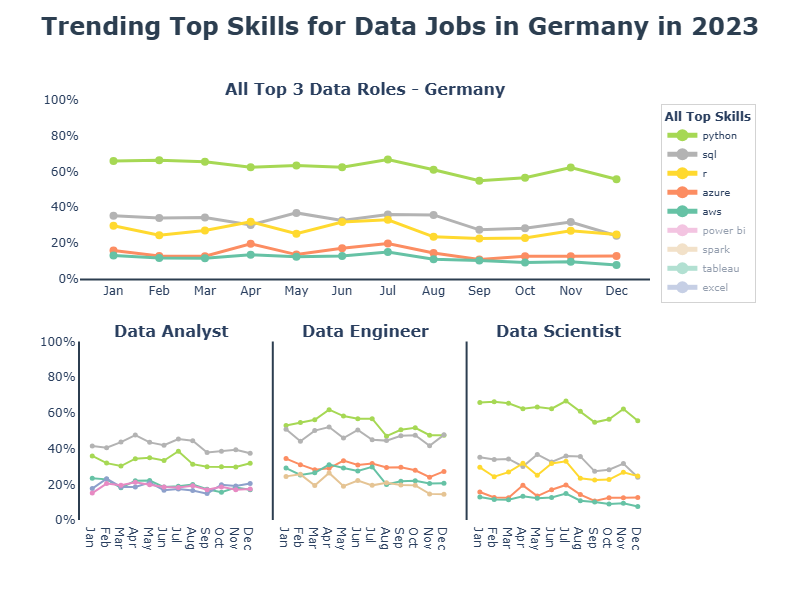

('docs/images/3.1. Data Jobs Germany - Top Skills Trends.png.png',
 'docs/images/3.1. Data Jobs Germany - Top Skills Trends.png.html')

In [ ]:
roles = ['Data Analyst', 'Data Engineer', 'Data Scientist']
all_skills = set()
for role in roles:
    all_skills.update(dfs_by_role[role].columns[:5].tolist())
all_skills.update(df_role_percent.columns[:5].tolist())

# Auto-generating colors using Plotly's color sequences
colors = px.colors.qualitative.Set2+ px.colors.qualitative.Set2 + px.colors.qualitative.Set1

# Creating skill_colors dictionary
skill_colors = {}
for idx, skill in enumerate(sorted(all_skills)):
    skill_colors[skill] = colors[idx % len(colors)]

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[
        '<b>All Top 3 Data Roles - Germany</b>',
        '<b>Data Analyst</b>', '<b>Data Engineer</b>', '<b>Data Scientist</b>'
    ],
    specs=[
        [{"colspan": 3}, None, None],
        [{}, {}, {}]
    ],
    shared_yaxes=True,
    vertical_spacing=0.15,
    horizontal_spacing=0.02
)

# Getting ALL skills for legend
all_skills_bottom = set()
for role in roles:
    all_skills_bottom.update(dfs_by_role[role].columns[:5].tolist())
top_plot_skills = df_role_percent.columns[:5].tolist()
all_skills_legend = list(set(top_plot_skills) | all_skills_bottom)


df_plot_total = df_role_percent.iloc[:, :5]
for skill in df_plot_total.columns[:5]:
    fig.add_trace(
        go.Scatter(
            x=df_plot_total.index,
            y=df_plot_total[skill],
            name=skill,
            mode='lines+markers',
            line=dict(color=skill_colors.get(skill, '#000000'), width=3),
            marker=dict(size=8),
            showlegend=True,  
            hovertemplate=f'{skill}: %{{y:.1f}}%<extra></extra>'
        ),
        row=1, col=1
    )

for col_idx, role in enumerate(roles, 1):
    df_role_plot = dfs_by_role[role].iloc[:, :5]
    
    for skill in df_role_plot.columns[:5]:
        fig.add_trace(
            go.Scatter(
                x=df_role_plot.index,
                y=df_role_plot[skill],
                name=skill,
                mode='lines+markers',
                line=dict(color=skill_colors.get(skill, '#000000'), width=2),
                marker=dict(size=5),
                showlegend=False,  
                hovertemplate=f'{role}<br>{skill}: %{{y:.1f}}%<extra></extra>'
            ),
            row=2, col=col_idx
        )

# Adding legend-only traces for skills not in top plot
skills_only_in_bottom = all_skills_bottom - set(top_plot_skills)

for skill in skills_only_in_bottom:
    fig.add_trace(
        go.Scatter(
            x=[None], 
            y=[None],
            name=skill,
            mode='lines+markers',
            line=dict(color=skill_colors.get(skill, '#000000'), width=3),
            showlegend=True,  
            hoverinfo='skip',
            visible='legendonly'  
        ),
        row=1, col=1
    )
# Updating layout
fig.update_layout(
    height=800,
    title=dict(
        text='<b>Trending Top Skills for Data Jobs in Germany in 2023</b>',
        font=dict(size=24, color='#2c3e50'),
        x=0.5,
        y=0.97
    ),
    plot_bgcolor='white',
    hovermode='x unified',
    legend=dict(
        title="<b>All Top Skills</b>",
        title_font=dict(size=12),
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.02,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='lightgray',
        borderwidth=1,
        font=dict(size=10),
        itemsizing='constant',
        itemwidth=30
    ),
    margin=dict(r=150)
)

for row in [1, 2]:
    for col in [1, 2, 3]:
        fig.update_yaxes(tickformat=',.0f', range=[0, 100], 
                        row=row, col=col, ticksuffix='%')


fig.update_yaxes(title_text='', row=1, col=1)
for col in [1, 2, 3]:
    fig.update_yaxes(title_text='', 
                     showline=True,
                    linewidth=2,
                    linecolor='#2c3e50', 
                    row=2, col=col)

fig.update_xaxes(
    showline=True,
    linewidth=2,
    linecolor='#2c3e50',  
    row=1, col=1
)

save_plot_for_github(fig, '3.1. Data Jobs Germany - Top Skills Trends.png')